In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import interpolation
from collections import defaultdict
from scipy.stats import circmean

class DataPoint:
    def __init__(self, s_n, s_n_1, r_n, r_n_1):
        self.s_n = s_n
        self.s_n_1 = s_n_1  
        self.r_n = r_n
        self.r_n_1 = r_n_1
    def __lt__(self, other):
        return self.s_n < other.s_n
    def to_numpy(self):
        return np.array([self.s_n, self.s_n_1, self.r_n])

gam_data_path = './base_bayesian_contour_1_circular_gam.pkl'

In [2]:
with open(gam_data_path, 'rb') as f:
    gam_data = pickle.load(f)
r_n_key = 'r_n_full_cleaned'
len(gam_data[r_n_key]), len(gam_data['s_n']), gam_data.keys()

(24219,
 24219,
 dict_keys(['r_n', 'pred_pairs', 'reg_dict', 'x_n', 'y_n', 'alpha', 'V_0', 'eta_0', 'Lambda_0', 'beta_0', 'V_n', 'eta_n', 'Lambda_n', 'beta_n', 'Y', 'Mean_error_covariance', 'Covariance_matrix', 'beta_0_contour', 'r_squ', 'posterior_contours', 'ranges', 'coef_inds', 'reg_list', 'full_X', 'full_pred', 'non_x_pred', 'pdf_mat', 'full_pdf_mat', 'full_vec_mat', 's_impacts', 'residual_variance', 'r_n_full_cleaned', 's_n']))

In [3]:
with open('./uniform_model_base_inv_kappa_free.pkl', 'rb') as f:
    Peter_u_map = pickle.load(f)
Peter_u_map.keys()

dict_keys(['samples', 'responses', 'sim_responses', 'seed', 'lr', 'log_u_sigma', 'pdf_centers', 'pdf_log_weights', 'pdf_log_widths', 'sim_hist', 'pdf', 'grid', 'losses'])

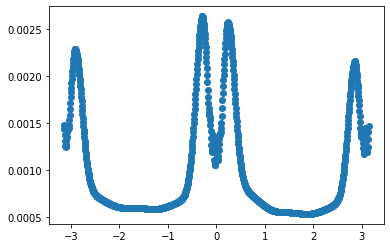

In [4]:
plt.plot(Peter_u_map['grid'], Peter_u_map['pdf'], 'o', label='Peter uniform model')

In [5]:
# Create dataset with s_n, s_n_1, r_n
serial_dep_data = np.zeros((len(gam_data['s_n'])-1, 5))
for index in range(len(gam_data['s_n'])-1):
    serial_dep_data[index, :] = np.array([gam_data['s_n'][index+1], gam_data['s_n'][index], gam_data[r_n_key][index+1], gam_data[r_n_key][index], index+1])

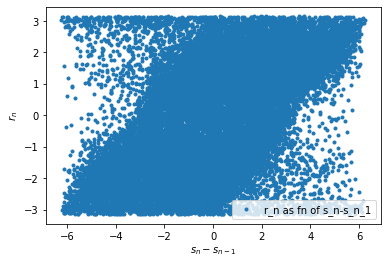

In [6]:
order_sn = np.argsort(serial_dep_data[:, 0])  # sort by the first column
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 1], serial_dep_data[order_sn, 2], '.', label='r_n as fn of s_n-s_n_1')
plt.xlabel('$s_n-s_{n-1}$')
plt.ylabel('$r_n$')
plt.legend()
plt.show()

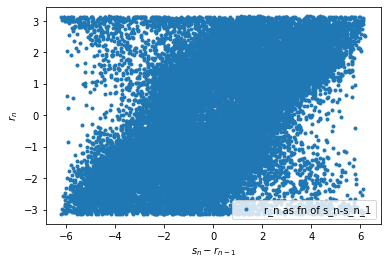

In [7]:
order_sn = np.argsort(serial_dep_data[:, 0])  # sort by the first column
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 3], serial_dep_data[order_sn, 2], '.', label='r_n as fn of s_n-s_n_1')
plt.xlabel('$s_n-r_{n-1}$')
plt.ylabel('$r_n$')
plt.legend()
plt.show()

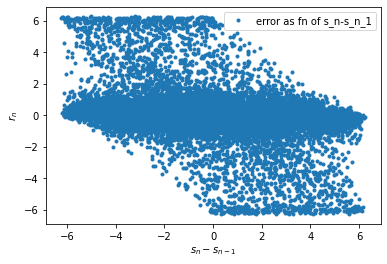

In [11]:
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 1], serial_dep_data[order_sn, 2] - serial_dep_data[order_sn, 0], '.', label='error as fn of s_n-s_n_1')
plt.xlabel('$s_n-s_{n-1}$')
plt.ylabel('$r_n$')
plt.legend()
plt.show()

In [8]:
def sn_to_mean_rn_map(s_ns, r_ns, sn_grid=None):
    if sn_grid is None:
        sn_grid = np.linspace(-np.pi, np.pi, 1000)
    responses = defaultdict(list)
    for sn, rn in zip(s_ns, r_ns):
        index_in_grid = int(interpolation.find_closest_mu_bs(mu=sn, mus=sn_grid))
        responses[index_in_grid].append(rn)
    mean_responses = np.array([circmean(high=np.pi, low=-np.pi, samples=responses[i]) for i in range(len(sn_grid))])
    return sn_grid, mean_responses

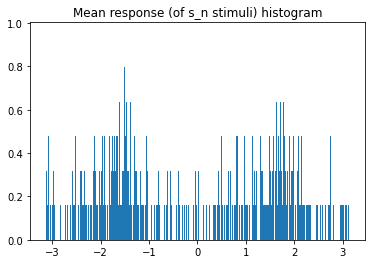

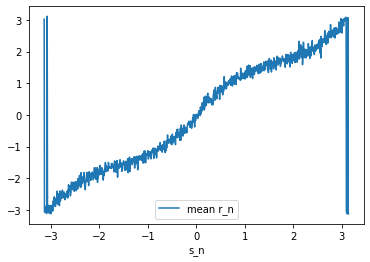

In [9]:
sn_grid, mean_r_n = sn_to_mean_rn_map(serial_dep_data[:, 0], serial_dep_data[:, 2], sn_grid=Peter_u_map['grid'])
bin_counts, _, _ = plt.hist(mean_r_n, bins=np.linspace(-np.pi, np.pi, len(sn_grid)+1), density=True)
plt.title('Mean response (of s_n stimuli) histogram')
plt.show()
# handle wrap
plt.plot(sn_grid, mean_r_n, label='mean r_n')
plt.xlabel('s_n')
plt.legend()
plt.show()
unif_fn_dict = {'grid': sn_grid, 'pdf': bin_counts, 'angle_to_u': mean_r_n}
with open('./mean_response_map.pkl', 'wb') as f:
    pickle.dump(unif_fn_dict, f)